In [7]:
import os
import sys
import random
import time
import matplotlib.pyplot as plt
import numpy as np

import mrppddl
from mrppddl import mcts, ff_heuristic

from typing import Dict, Set, Tuple, List, Callable
from object_search.core import Fluent, State, Operator, Effect, transition, get_next_actions
from object_search.utils import compute_cost_and_trajectory
import object_search.plotting
import procthor
from procthor.simulators import SceneGraphSimulator
from common import Pose
from object_search.robot import Robot

# ——————————————————————————————————————————————————————————————————————————————
# 1) Fluent computation (no 'near')
# ——————————————————————————————————————————————————————————————————————————————
def compute_fluents(
    robot_pos: Tuple[int,int],
    partial: Dict[int,dict],
    holding: Set[str],
    searched: Set[str]
) -> Set[Fluent]:
    fs: Set[Fluent] = set()
    fs.add(Fluent('free','robot'))
    # container/location nodes
    for idx,node in partial.items():
        ntype = node['type']
        nid = node['id']
        x,y = node['position']
        # at(robot, loc)
        if ntype == [0, 0, 1, 0]:
            fs.add(Fluent('at','robot',nid) if robot_pos==(x,y) else ~Fluent('at','robot',nid))
            # searched(loc)
            fs.add(Fluent('searched',nid) if nid in searched else ~Fluent('searched',nid))
        # holding markers
        elif ntype == [0, 0, 0, 1]:
            fs.add(Fluent('holding','robot',nid) if nid in holding else ~Fluent('holding','robot',nid))
    # discovered object nodes
    for node in partial.values():
        if node['type']==[0,0,0,1]:
            # at(object, loc) fluent: object assumed at robot_pos if held or found
            for loc in partial.values():
                if loc['type']==[0,0,1,0]:
                    d = abs(node['position'][0]-loc['position'][0]) + abs(node['position'][1]-loc['position'][1])
                    fs.add(Fluent('at',node['id'],loc['id']) if d<=0 else ~Fluent('at',node['id'],loc['id']))
    return frozenset({f for f in fs if not f.negated})

# ——————————————————————————————————————————————————————————————————————————————
# 2) State subclass and detailed transition
# ——————————————————————————————————————————————————————————————————————————————
class RobotState(State):
    def __init__(self, time=0, fluents=None,
                 robot_pos=(0,0), holding=None, searched=None):
        super().__init__(time=time, fluents=fluents)
        self.robot_pos = robot_pos
        self.holding = holding or set()
        self.searched = searched or set()
    def copy(self):
        return RobotState(
            time=self.time,
            fluents=set(self.fluents),
            robot_pos=self.robot_pos,
            holding=set(self.holding),
            searched=set(self.searched)
        )

# enhanced transition that mutates partial_map
def transition_with_position(
    state: RobotState,
    action: Operator,
    full_map: Dict[int,dict],
    partial_map: Dict[int,dict]
) -> RobotState:
    new = state.copy()
    name = action.name
    # move_to updates robot_pos
    if name.startswith('move_to') or name.startswith('search'):
        loc = name.split()[-1]
        new.robot_pos = full_map[next(i for i,n in full_map.items() if n['id']==loc)]['position']
    # search reveals objects
    if name.startswith('search'):
        loc = name.split()[-1]
        new.searched.add(loc)
        # add object children from full_map at this loc
        for i,n in full_map.items():
            if n['type']==[0,0,0,1] and n['position']==new.robot_pos:
                partial_map[i] = n
    # pick_up updates holding and moves object
    if name.startswith('pick_up'):
        obj = name.split()[2]
        new.holding.add(obj)
        full_map[next(i for i,n in full_map.items() if n['id']==obj)]['position'] = new.robot_pos
        # remove that object from partial_map safely
        to_remove = [nid for nid, data in partial_map.items() if data['id'] == obj]
        for nid in to_remove:
            partial_map.pop(nid)
    # core semantic fluents and time
    out = transition(state, action)
    if out: new.time = out[0][0].time
    # recompute fluents on updated partial_map
    print(new.searched)
    new.fluents = compute_fluents(new.robot_pos, partial_map, new.holding, new.searched)
    return new

# ——————————————————————————————————————————————————————————————————————————————
# 3) Operators: move_to, search, pick_up, wait
# ——————————————————————————————————————————————————————————————————————————————
def make_ops(
    full_map: Dict[int,dict],
    get_robot_pos: Callable[[],Tuple[int,int]]
) -> List[Operator]:
    def move_cost(_robot, loc_to, fm=full_map):
        rx,ry = get_robot_pos()
        # use fm (not full_map) for lookup
        for node in fm.values():
            if node['id']==loc_to:
                tx,ty = node['position']
                return abs(rx-tx)+abs(ry-ty)
        return float('inf')
    move = Operator(
        'move_to',[('?robot','robot'),('?loc_to','location')],
        [Fluent('free robot')],
        [Effect(0, resulting_fluents={~Fluent('free robot')}),
         Effect((move_cost,['?robot','?loc_to']), resulting_fluents={Fluent('free robot'), Fluent('at robot ?loc_to')})]
    )
    search = Operator(
        'search',[('?robot','robot'),('?loc_to','location')],
        [Fluent('free robot'), ~Fluent('searched ?loc_to')],
        [Effect(5, resulting_fluents={Fluent('searched ?loc_to')})]
    )
    pick = Operator(
        'pick_up',[('?robot','robot'),('?obj','object'),('?loc','location')],
        [Fluent('at robot ?loc'), Fluent('at ?obj ?loc'), Fluent('free robot'), ~Fluent('holding robot ?obj')],
        [Effect(0, resulting_fluents={~Fluent('free robot')}), Effect(5, resulting_fluents={Fluent('holding robot ?obj')})]
    )
    wait = Operator(
        'wait',[('?robot','robot')],
        [Fluent('free robot'), ~Fluent('waited robot')],
        [Effect(0, resulting_fluents={~Fluent('free robot')}), Effect(10, resulting_fluents={Fluent('free robot'), Fluent('waited robot')})]
    )
    return [move,search,pick,wait]

# ——————————————————————————————————————————————————————————————————————————————
# 4) Unity loop integrating ProcTHOR
# ——————————————————————————————————————————————————————————————————————————————
def get_args():
    a=lambda k:None; a.current_seed=3; a.resolution=0.05; a.save_dir='/data/logs'; a.network_file=''; a.do_save_video=False; return a

def describe_state(state: RobotState) -> str:
    fluents = state.fluents

    # 1) Robot position: fluent "at robot LOC"
    pos_f = next(
        (f for f in fluents if f.name == "at" and f.args[0] == "robot"),
        None
    )
    robot_pos = pos_f.args[1] if pos_f else "unknown"

    # 2) Free / busy
    is_free = any(f.name == "free" for f in fluents)
    status = "free" if is_free else "busy"

    # 3) Searched locations: fluent "searched LOC"
    searched = sorted(f.args[0]
                      for f in fluents
                      if f.name == "searched")

    # 4) Held objects: fluent "holding robot OBJ"
    holding = sorted(f.args[1]
                     for f in fluents
                     if f.name == "holding" and f.args[0] == "robot")

    # 5) Objects at this spot: fluent "at OBJ LOC"
    at_here = sorted(f.args[0]
                     for f in fluents
                     if f.name == "at"
                     and f.args[0] != "robot"
                     and f.args[1] == robot_pos)

    lines = [
        f"Robot is at:        {robot_pos}",
        f"Robot status:       {status}",
        f"Searched so far:    {', '.join(searched) or '(none)'}",
        f"Holding:            {', '.join(holding) or '(nothing)'}",
        f"Objects at this loc:{', '.join(at_here) or '(none)'}",
    ]
    return "\n".join(lines)

def run_manual_loop():
    args = get_args()
    thor = procthor.ThorInterface(args)

    # initial known map from ProcTHOR
    known_graph, grid, init_pose, tinfo = thor.gen_map_and_poses()
    target_name = tinfo['name']
    target_id = None
    for node in known_graph.nodes.values():
        # your nodes might store the name under a different key; adjust as needed
        if node.get("name") == target_name:
            target_id = node["id"]
            break
    if target_id is None:
        raise RuntimeError(f"Couldn't find an object named {target_name!r} in the graph.")
    print(f"■ Planning to pick up object {target_name!r} with ID {target_id!r}")
    sim = SceneGraphSimulator(known_graph, args, tinfo, grid, thor)
    robot = Robot(init_pose)

    # build full_map and partial_map dicts
    full_map = known_graph.nodes
    partial_map = {i:n for i,n in full_map.items() if n['type']==[0,0,1,0]}

    # dynamic get_robot_pos closure
    current_pos = (init_pose.x, init_pose.y)
    def get_robot_pos(): return current_pos

    def goal_fn(fluents):
        # succeed when we're holding the target
        return Fluent("holding", "robot", target_id) in fluents

    ff_memory = {}

    # build operators and instantiate
    ops = make_ops(full_map, get_robot_pos)
    objects_by_type = {
        'robot':['robot'],
        'location':[n['id'] for n in full_map.values() if n['type']==[0,0,1,0]],
        'object':[n['id'] for n in full_map.values() if n['type']==[0,0,0,1]]
    }
    all_actions = []
    for op in ops:
        all_actions += op.instantiate(objects_by_type)

    # initial state
    state = RobotState(
        time=0.0,
        fluents=frozenset(compute_fluents(current_pos, partial_map, set(), set())),
        robot_pos=current_pos,
        holding=set(),
        searched=set()
    )

    done = False

    # 1) Compute cost & trajectory on the current grid
    cost, trajectory = compute_cost_and_trajectory(grid, robot.all_poses)
    if trajectory is None:
        # no movement yet → plot a single point
        xs = [p.x for p in robot.all_poses]
        ys = [p.y for p in robot.all_poses]
        trajectory = (xs, ys)

    # 2) Plot into the bottom‐right subplot
    ax = plt.subplot(224)
    object_search.plotting.plot_grid_with_robot_trajectory(
        ax,
        grid,                # known_grid
        robot.all_poses,
        trajectory,
        known_graph
    )
    ax.set_title(f"Inital State")
    plt.show()

    # manual planning loop
    while not done:
        plt.imshow(sim.get_top_down_image()); plt.axis('off'); plt.show()
        
        # refresh action domains
        objects_by_type['location'] = [n['id'] for n in partial_map.values() if n['type']==[0,0,1,0]]
        objects_by_type['object']   = [n['id'] for n in partial_map.values() if n['type']==[0,0,0,1]]
        available = [a for a in all_actions if state.satisfies_precondition(a)]
        policy, root = mcts(
            root_state=state,
            all_actions=available,
            goal_fn=goal_fn,
            heuristic_fn=lambda s: ff_heuristic(s, goal_fn, available, ff_memory=ff_memory),
            max_iterations=500,
            max_depth=15
        )
        # 3c) Extract the best action for *this* state
        act = policy.get(state)
        if act is None:
            print("⚠️  MCTS failed to pick an action; aborting.")
            break
        print(f">>> MCTS recommends: {act.name}")
        # for i,a in enumerate(available): print(f"[{i}] {a.name}")
        # choice = int(input('> ')); act = available[choice]
        # apply transition
        
        state = transition_with_position(state, act, full_map, partial_map)
        current_pos = state.robot_pos
        # drive in Unity - Modify this section with full robot movement
        robot.move(Pose(*current_pos))
        # update known_graph for sim
        known_graph, grid, _, _ = thor.gen_map_and_poses()
        sim.observed_graph = known_graph
        print(describe_state(state))
        # print('State:', state)
        # print('Robot Pose:', get_robot_pos())

        # 1) Compute cost & trajectory on the current grid
        cost, trajectory = compute_cost_and_trajectory(grid, robot.all_poses)
        if trajectory is None:
            # no movement yet → plot a single point
            xs = [p.x for p in robot.all_poses]
            ys = [p.y for p in robot.all_poses]
            trajectory = (xs, ys)
    
        # 2) Plot into the bottom‐right subplot
        ax = plt.subplot(224)
        object_search.plotting.plot_grid_with_robot_trajectory(
            ax,
            grid,                # known_grid
            robot.all_poses,
            trajectory,
            known_graph
        )
        ax.set_title(f"Inital State")
        plt.show()
        
        if target_id in state.holding:
            print("🎉 Acquired target, exiting.")
            done = True

-----------Using cached procthor data-----------
■ Planning to pick up object 'kettle' with ID 'kettle|surface|6|16'


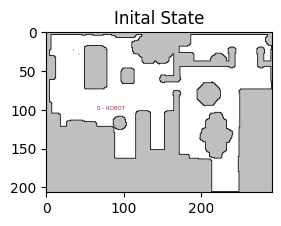

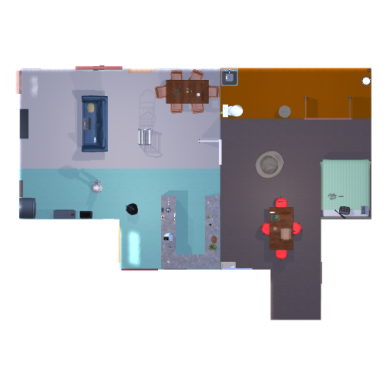

>>> MCTS recommends: search robot garbagecan|6|3
{'garbagecan|6|3'}
Robot is at:        garbagecan|6|3
Robot status:       free
Searched so far:    garbagecan|6|3
Holding:            (nothing)
Objects at this loc:(none)


KeyboardInterrupt: 

In [8]:
run_manual_loop()